In [143]:
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
import cv2
# USED MODEL
from tensorflow.keras.applications import vgg19

In [249]:
# zaczniemy od przekopiowania stylu dwurnika na zdjęcie takie samo jak jego obraz 
plac_zbawiciela_dwur_loc = './obrazy/Pejzaze/Dwurnik/Plac_Zbawiciela_dwurnik.jpeg'
plac_zbawiciela_real_loc = './obrazy/plac_zbawiciela1.jpg'

In [250]:
# funkcje obsługujące obrazy wynikiem jest tablica np.array
def load_image(location):
    image = cv2.imread(location)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return np.array(image)

        
# funkcja wyświetlająco obrazy w rzędzie, można podac listę obrazów do wyświetlenia 
def plot_images(images, num_rows = 1):
    n = len(images)
    num_cols = np.ceil(n/num_rows)
    fig,axes = plt.subplots(ncols = int(num_cols),nrows = int(num_rows))
    axes = axes.flatten()
    fig.set_size_inches((15,15))
    for i,image in enumerate(images):
        axes[i].imshow(image)

(2043, 2460, 3)
(600, 900, 3)


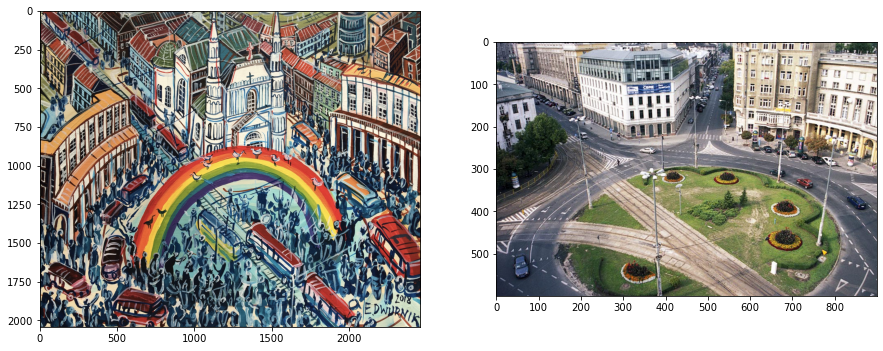

In [251]:
# load and disply images 
plac_zbawiciela_dwur_img = load_image(plac_zbawiciela_dwur_loc)
plac_zbawiciela_real_img = load_image(plac_zbawiciela_real_loc)

print(plac_zbawiciela_dwur_img.shape)
print(plac_zbawiciela_real_img.shape)

plot_images([plac_zbawiciela_dwur_img, plac_zbawiciela_real_img])

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


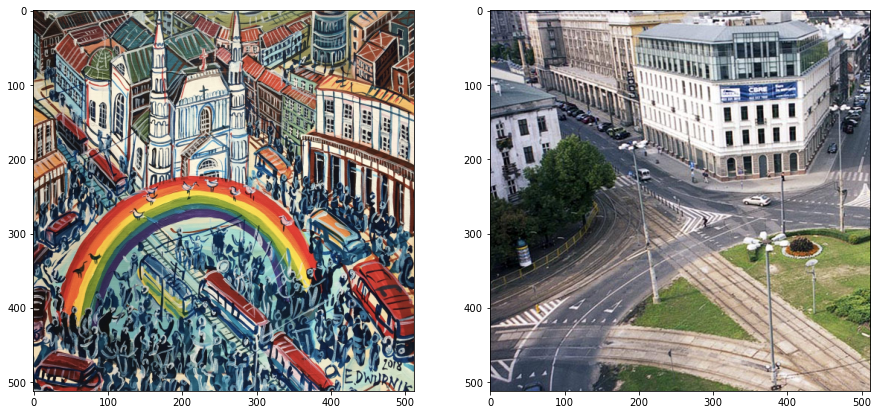

In [252]:
# obcięcie rozmiaru zdjęć do kwadratu i zmniejszenie
plac_zbawiciela_real_img = plac_zbawiciela_real_img[0:512,0:512,:]
plac_zbawiciela_dwur_img = plac_zbawiciela_dwur_img[0:2000,460:2460,:]
plac_zbawiciela_dwur_img = cv2.resize(plac_zbawiciela_dwur_img, 
                                      (512,512), interpolation = cv2.INTER_AREA)
                                      
print(plac_zbawiciela_dwur_img.shape)
print(plac_zbawiciela_real_img.shape)

#plac_zbawiciela_dwur_img = np.array(plac_zbawiciela_dwur_img.resize((500,500)))

print(plac_zbawiciela_dwur_img.shape)

plot_images([plac_zbawiciela_dwur_img, plac_zbawiciela_real_img])

In [253]:
# import i uruchomienie modelu 
base_model = vgg19.VGG19(include_top=False, weights='imagenet')
print(base_model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#### Sprawdzenie jak będzie wyglądał przetworzony obraz

In [254]:
# dwa obrzy są używane, jeden to style [obraz artysty], a drugi to content [przetwarzane zdjęcie]
style_image = plac_zbawiciela_dwur_img
content_image = plac_zbawiciela_real_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512, 3)
(512, 512, 3)
<class 'numpy.ndarray'>


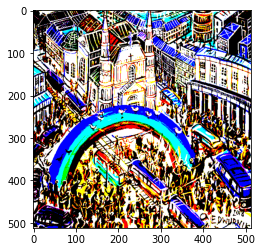

In [255]:
# sprawdzenie przetwarzania któe wykonuje sieć
process_example_img = vgg19.preprocess_input(np.expand_dims(style_image, axis=0))
print(process_example_img.shape)
print(process_example_img[0].shape)
print(type(process_example_img))

plt.imshow(process_example_img[0])

# jest ok, dodaliśmy jeden wymiar do obrazu, sztucznie bo sieć wymaga dodatkowych wejść, 
# widać jednak, że zmieniły się bardzo kolory, i taki zmienionybędzie obraz wyjściowy, 
# po pierwsze mamy zastosowane do kanałów koloru biasy, dodatkowo, zmieniana jest RGB na BGR
# od razu warto dopisać funkcję odwracającą zmiany kolorów

In [256]:
# sprawdzenie wartości biasów
VGG_BIASES = vgg19.preprocess_input((np.zeros((3))).astype("float32"))
# funkcja deprocessu
def deprocess (start_image):
    fin_image = start_image - VGG_BIASES
    fin_image = tf.unstack(fin_image,axis=-1)
    fin_image = tf.stack([fin_image[2],fin_image[1],fin_image[0]],axis=-1)
    return fin_image

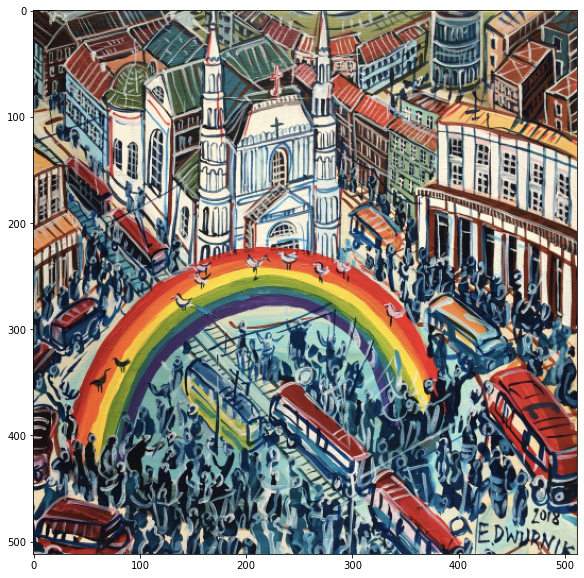

In [257]:
# sprawdzenie działania funkcji odwracającej działanie sieci na obrazie wyjściowym
plt.figure(figsize=(10,10))
plt.imshow(deprocess(process_example_img[0])/255)

### Tworzenie modelu to pobrania stylu 
W modelu style transfer po wstepnym nauczeniu sieci stosujemy sieć i jej części gdzie zapisane są cechy główne do zmiany obrau wejściowego. Ta operacja powtarza się wielokrotnie.

In [258]:
CONTENT_LAYERS = ["block5_conv2"] # przykładowa warstwa z której pobierzemy kontent po jednym obrocie
STYLE_LAYERS = ["block4_conv1",
                "block4_conv2",
                "block4_conv3",
                "block4_conv4"] # te warstwy zawierają cechy stylu

In [259]:
# zdefiniowanie modeli do testów, pełnego VGG19, bez pierwszych warstw i dla różnych rozmiarów
def make_model(full=False, in_shape=None):
    if full:    
        base_model = vgg19.VGG19(inclued_top=True, weights='imegenet')
        return base_model
    if in_shape != None:
        base_model = vgg19.VGG19(inclued_top=False, input_shape=in_shape, weights='imegenet')
    else:
        base_model=vgg19.VGG19(include_top=False,weights="imagenet")
    # w metodzie style transfer, optymalizację nie wykonujemy na modelu, ale na obrazie transformowanym 
    base_model.trainable = False
    content_layers = CONTENT_LAYERS
    style_layers = STYLE_LAYERS
    output_layers = [base_model.get_layer(layer).output for layer in (content_layers+style_layers)]
    return tf.keras.models.Model(base_model.input,output_layers)

In [260]:
# stworzenie modelu 
base_model = make_model()

In [261]:
# aby użyć przerobionego modelu VGG19 należy na wejścia podać przeprocesowane obrazy 
processed_dwur_img = vgg19.preprocess_input(np.expand_dims(plac_zbawiciela_dwur_img, axis = 0))
processed_real_img = vgg19.preprocess_input(np.expand_dims(plac_zbawiciela_real_img, axis = 0))

In [262]:
# otrzymanie pierwszych danych wyjściowych
outputs_dwur_img = base_model(processed_dwur_img)
outputs_real_img = base_model(processed_real_img)

In [263]:
# wyciągnięcie odpowiednichcech stylu z obrazów
content_dwur_img = outputs_dwur_img[0]
content_real_img = outputs_real_img[0]

#### Teraz nalezy zbudować odpowiednią funkcję porównania stylu i kontentu 
użyta zostanie tutaj macierz Gramma do różnicy styli obu obrazów oraz zwykła MSE do różnicy kontentów
MSE ma posłóżyć zachowaniu oryginalnego wyglądu kontentu (np. pies ma zostać psem, ale o zmienionym stylu)

In [264]:
# funkcja straty kontentu między dwoma obrazami MSE
def content_loss(img_new, img_base):
    return np.mean(np.square(img_new - img_base))

In [265]:
# funkcja straty stylu, implementację wziąłem z internetu
# w skrócie macierz Gramma to macierz wszystkich możliwych relacji między cechami obrazu
def gram_matrix(output):
    first_style_layer = output
    A = tf.reshape(first_style_layer,(-1,first_style_layer.shape[-1]))
    n = A.shape[0]
    gram_matrix = tf.matmul(A,A,transpose_a = True)
    n = gram_matrix.shape[0]
    return gram_matrix/tf.cast(n,"float32"),n

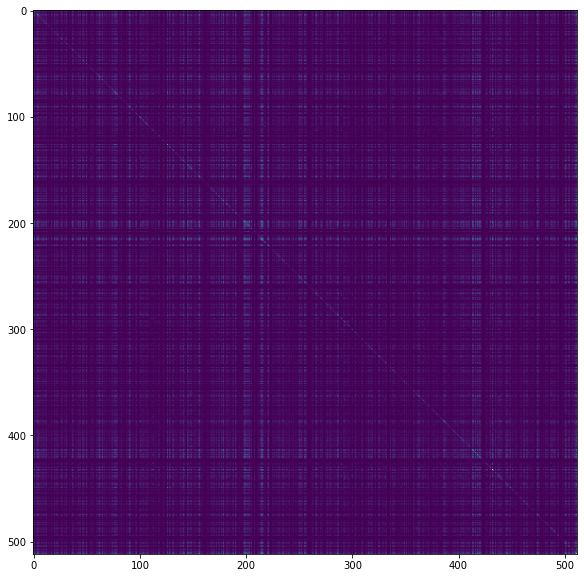

In [266]:
# Macierz dla warstw styli które wyciągnęliśmy z obrazu stylu
gram_matrix_img, N = gram_matrix(outputs_dwur_img[2])

plt.figure(figsize=(10,10))
plt.imshow(gram_matrix_img.numpy())

In [267]:
def style_loss(style_new, style_base):
    style_new_gram, gram_height1 = gram_matrix(style_new)
    style_base_gram, gram_height2 = gram_matrix(style_base)
    assert gram_height1 == gram_height2
    num_features = style_new_gram.shape[0]
    loss = tf.reduce_sum(tf.square(style_base_gram-style_new_gram)/(4*int(gram_height1)**2)*(int(num_features)**2))
    return loss
    

In [268]:
# połącznie błędu kontentu i stylu 
# współczynnik pozwoli na dopasowanie stosunku wagi stylu do zachowania kontentu
def total_loss(new_image_output,base_content_image_output,base_style_image_output,alpha=.999):
    new_image_styles = new_image_output[len(CONTENT_LAYERS):]
    base_image_styles = base_style_image_output[len(CONTENT_LAYERS):]
    style_loss_val = 0
    N = len(new_image_styles)
    for i in range(N):
        style_loss_val += style_loss(new_image_styles[i], base_image_styles[i])   
    
    new_image_contents = new_image_output[:len(CONTENT_LAYERS)]
    base_image_contents = base_content_image_output[:len(CONTENT_LAYERS)]
    content_loss_val = 0
    N = len(new_image_contents)
    for i in range(N):
        content_loss_val += content_loss(new_image_contents[i],base_image_contents[i])/N
    
    return (1-alpha)*style_loss_val+alpha*content_loss_val

In [269]:
# strata przetworzenia pierwszej rotacji 
total_loss(outputs_dwur_img, outputs_real_img, outputs_dwur_img)

<tf.Tensor: id=199743, shape=(), dtype=float32, numpy=6204.1543>

### Training
Po przygotowaniu wszystkich elementów można uruchomić procedurę przetwarzania obrazu 

In [338]:
base_style_outputs = base_model(processed_dwur_img)
base_content_outputs = base_model(processed_real_img)

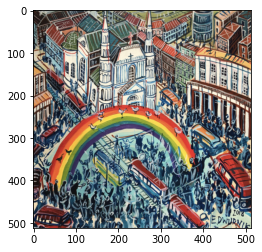

In [339]:
plt.imshow(deprocess(processed_dwur_img[0])/255)

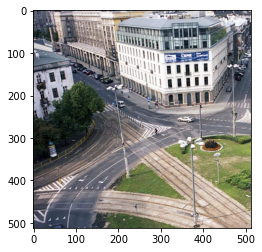

In [340]:
plt.imshow(deprocess(processed_real_img[0])/255)

In [341]:
# !!!! Można spróbować dodać trochę szumu do tego, żeby obraz lepiej poddał się content loss !!!!!
# +tf.random.normal(processed_real_img.shape)
processed_content_var = tf.Variable(processed_real_img+tf.random.normal(processed_real_img.shape))

In [342]:
optimizer = tf.keras.optimizers.Adam(5, beta_1=.99, epsilon=1e-3)

In [343]:
from IPython.display import display,clear_output

In [344]:
images = []
losses = []
i = 0 
# na początek coś dużego, tak o dla ogarnięcia jak to wyjdzie
best_loss = 200000
min_vals = VGG_BIASES
max_vals = VGG_BIASES + 255

for i in range(200):
    with tf.GradientTape() as tape:
        print(loss)
        tape.watch(processed_content_var)
        content_var_outputs = base_model(processed_content_var)
        loss = total_loss(content_var_outputs,base_content_outputs,base_style_outputs,alpha=.9999)
        grad = tape.gradient(loss,processed_content_var)
        losses.append(loss)
        optimizer.apply_gradients(zip([grad],[processed_content_var]))
        # obcinamy do wartości dopuszczalnych, po deprocessingu muszą być rozpownawalne
        clipped = tf.clip_by_value(processed_content_var, min_vals, max_vals)
        processed_content_var.assign(clipped)       
        if i%5 == 0:
            images.append(deprocess(processed_content_var))
        if loss < best_loss:
            # nadajemy nowy loss jako best i przypisujemy best_img
            best_image = processed_content_var
            best_loss=loss
            
        clear_output(wait=True)

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
<tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32, numpy=
array([[[[  -7.0391555 ,  104.03068   ,  -45.59819   ],
         [ -13.41153   ,   29.742462  ,  -52.613457  ],
         [  45.472042  ,   46.58735   ,  -57.382782  ],
         ...,
         [  87.60875   ,    6.3140078 ,  112.42783   ],
         [   3.2781427 ,   55.25811   ,   82.4656    ],
         [  93.84396   ,  110.16992   ,  130.07788   ]],

        [[ -46.884422  ,  115.546776  ,  -23.793867  ],
         [  29.659998  ,   54.65847   ,  -13.155416  ],
         [  34.82989   ,   43.72863   ,  -40.158672  ],
         ...,
         [ 117.7393    ,    9.590543  ,  125.599594  ],
         [   9.176617  ,   55.174557  ,   86.73813   ],
         [  55.395084  ,   75.7417    ,   99.241234  ]],

        [[-101.09871   ,  -23.189556  , -110.94329   ],
         [ -89.24355   ,  1

In [352]:
len(images)

40

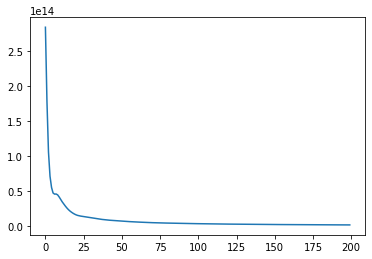

In [353]:
plt.plot(losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


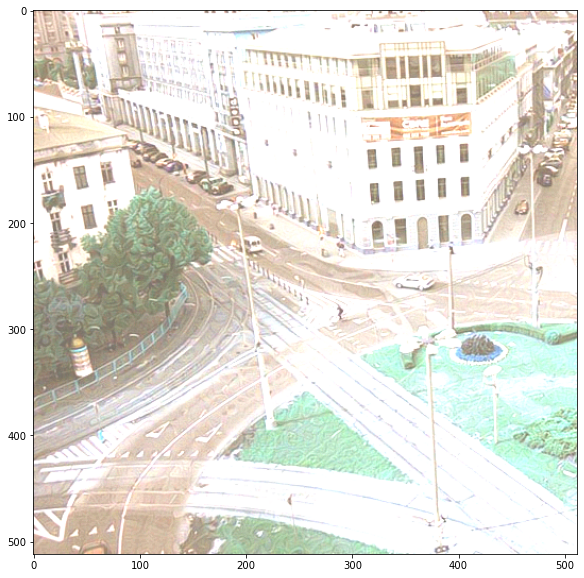

In [354]:
image_deproc = deprocess(images[0][0])

plt.figure(figsize=(10,10))
plt.imshow(image_deproc/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


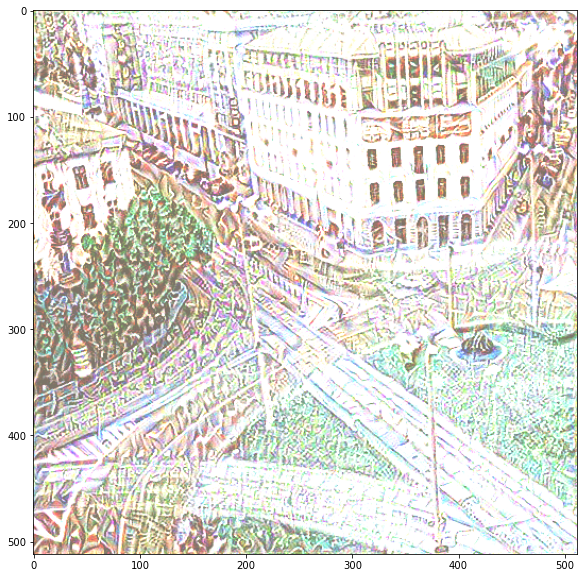

In [355]:
image_deproc = deprocess(images[10][0])

plt.figure(figsize=(10,10))
plt.imshow(image_deproc/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


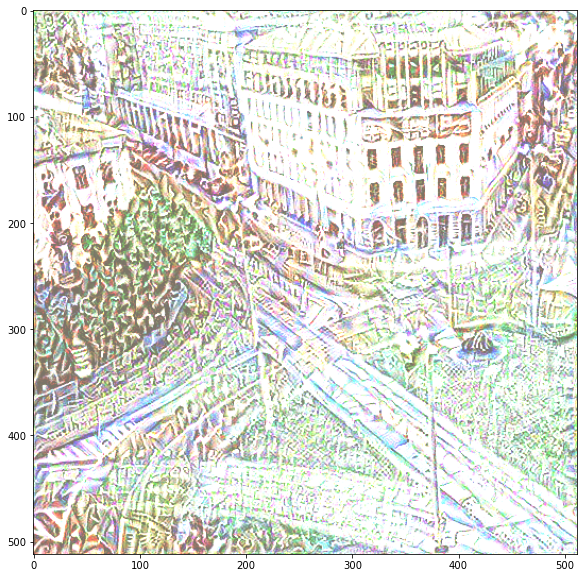

In [351]:
image_deproc = deprocess(images[20][0])

plt.figure(figsize=(10,10))
plt.imshow(image_deproc/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


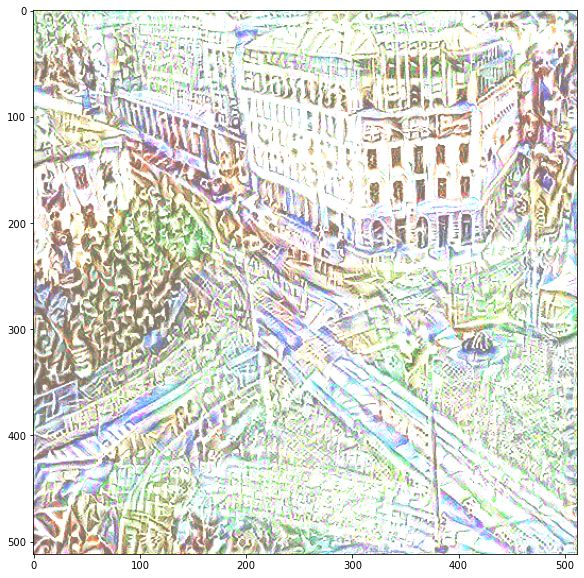

In [357]:
image_deproc = deprocess(images[39][0])

plt.figure(figsize=(10,10))
plt.imshow(image_deproc/255)